# Functions

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.patches as mpatches
from scipy.optimize import minimize, differential_evolution

# FUNCTIONS FOR 2 PHASES

def mixture_skew_normal_2(x, w1, w2, loc1, scale1, alpha1, loc2, scale2, alpha2):
    return w1 * skewnorm.pdf(x, alpha1, loc=loc1, scale=scale1) + \
           w2 * skewnorm.pdf(x, alpha2, loc=loc2, scale=scale2)

# Error function for hardness
def error_function(params, bin_centers, hist):
    w1, loc1, d, scale1, alpha1, scale2, alpha2 = params
    loc2 = loc1 + d
    w2 = 1 - w1
    y_fit = mixture_skew_normal_2(bin_centers, w1, w2, loc1, scale1, alpha1, loc2, scale2, alpha2)
    return np.sum((hist - y_fit) ** 2)

# Error function for Modulus fitting (w1 and w2 are fixed)
def error_function_modulus(params_mod, bin_centers_mod, hist_mod):
    loc1, d, scale1, alpha1, scale2, alpha2 = params_mod
    loc2 = loc1 + d
    y_fit_modulus = w1_fixed * skewnorm.pdf(bin_centers_mod, alpha1, loc=loc1, scale=scale1) + \
                    w2_fixed * skewnorm.pdf(bin_centers_mod, alpha2, loc=loc2, scale=scale2)
    return np.sum((hist_mod - y_fit_modulus) ** 2)

def skew_normal_mode(loc, scale, alpha):
    return loc + scale * (alpha / np.sqrt(1 + alpha**2))

def skew_normal_stddev(scale, alpha):
    return scale * np.sqrt(1 - (2 * alpha**2 / (np.pi * (1 + alpha**2))))

# Function to calculate mode and standard deviation for hardness and modulus
def calculate_skew_normal_stats_2(params_hardness, loc2_hardness, params_modulus, loc2_modulus):
    # Hardness Phase 1 and Phase 2 statistics
    loc1_hardness = params_hardness[1]
    scale1_hardness = params_hardness[3]
    alpha1_hardness = params_hardness[4]

    scale2_hardness = params_hardness[5]
    alpha2_hardness = params_hardness[6]

    # Calculate the mode and standard deviation for Hardness Phase 1
    mode1_hardness = skew_normal_mode(loc1_hardness, scale1_hardness, alpha1_hardness)
    stddev1_hardness = skew_normal_stddev(scale1_hardness, alpha1_hardness)

    # Calculate the mode and standard deviation for Hardness Phase 2
    mode2_hardness = skew_normal_mode(loc2_hardness, scale2_hardness, alpha2_hardness)
    stddev2_hardness = skew_normal_stddev(scale2_hardness, alpha2_hardness)

    # Modulus Phase 1 and Phase 2 statistics
    loc1_modulus = params_modulus[0]
    scale1_modulus = params_modulus[2]
    alpha1_modulus = params_modulus[3]

    scale2_modulus = params_modulus[4]
    alpha2_modulus = params_modulus[5]

    # Calculate the mode and standard deviation for Modulus Phase 1
    mode1_modulus = skew_normal_mode(loc1_modulus, scale1_modulus, alpha1_modulus)
    stddev1_modulus = skew_normal_stddev(scale1_modulus, alpha1_modulus)

    # Calculate the mode and standard deviation for Modulus Phase 2
    mode2_modulus = skew_normal_mode(loc2_modulus, scale2_modulus, alpha2_modulus)
    stddev2_modulus = skew_normal_stddev(scale2_modulus, alpha2_modulus)

    # Return results as a dictionary
    return {
        "Hardness Phase 1": {"Mode": mode1_hardness, "Standard Deviation": stddev1_hardness},
        "Hardness Phase 2": {"Mode": mode2_hardness, "Standard Deviation": stddev2_hardness},
        "Modulus Phase 1": {"Mode": mode1_modulus, "Standard Deviation": stddev1_modulus},
        "Modulus Phase 2": {"Mode": mode2_modulus, "Standard Deviation": stddev2_modulus}
    }


def plot_clusters_2(X, Y, df, params_hardness, params_modulus, loc2_hardness, loc2_modulus, w1_fixed, w2_fixed, s, weight_hardness=0.5, weight_modulus=0.5):

    # Define colors for the two phases (hardness and modulus)
    colors = ['blue', 'red']

    # HARDNESS probabilities for 2 phases
    probabilities_hardness = np.zeros((len(X), 2))  # We have two components for hardness
    for i, x in enumerate(X):
        p1_hardness = params_hardness[0] * skewnorm.pdf(x, params_hardness[4], loc=params_hardness[1], scale=params_hardness[3])
        p2_hardness = w2_fixed * skewnorm.pdf(x, params_hardness[6], loc=loc2_hardness, scale=params_hardness[5])
        total_prob_hardness = p1_hardness + p2_hardness
        probabilities_hardness[i] = [p1_hardness / total_prob_hardness, p2_hardness / total_prob_hardness]

    # MODULUS probabilities for 2 phases
    probabilities_modulus = np.zeros((len(Y), 2))  # We have two components for modulus
    for i, y in enumerate(Y):
        p1_modulus = w1_fixed * skewnorm.pdf(y, params_modulus[3], loc=params_modulus[0], scale=params_modulus[2])
        p2_modulus = w2_fixed * skewnorm.pdf(y, params_modulus[5], loc=loc2_modulus, scale=params_modulus[4])
        total_prob_modulus = p1_modulus + p2_modulus
        probabilities_modulus[i] = [p1_modulus / total_prob_modulus, p2_modulus / total_prob_modulus]

    # Combine the normalized probabilities using weighted combination for hardness and modulus
    combined_probabilities_weighted = (weight_hardness * probabilities_hardness) + \
                                      (weight_modulus * probabilities_modulus)

    # Assign each data point to a cluster based on combined weighted probabilities
    combined_clusters_weighted = np.argmax(combined_probabilities_weighted, axis=1) + 1  # Cluster labels start from 1

    # Calculate the percentage of data points in each cluster
    cluster_1_count = np.sum(combined_clusters_weighted == 1)
    cluster_2_count = np.sum(combined_clusters_weighted == 2)

    total_points = len(combined_clusters_weighted)

    percentage_cluster_1 = (cluster_1_count / total_points) * 100
    percentage_cluster_2 = (cluster_2_count / total_points) * 100

    # Print the percentage of data points in each cluster
    print(f"Cluster 1: {percentage_cluster_1:.2f}% of the data points")
    print(f"Cluster 2: {percentage_cluster_2:.2f}% of the data points")

    # Plot a scatterplot of the clusters in X Position vs Y Position with normalized and weighted probabilities
    plt.figure(figsize=(7, 7))  # Set the figure size to 7x7 inches
    scatter = plt.scatter(df['X'], df['Y'], c=[colors[i-1] for i in combined_clusters_weighted], marker='s', s=s)

    # Create custom legend handles for X and Y positions
    legend_handles_combined_weighted = []
    for cluster_combined in range(1, 3):  # Now 2 clusters
        color = colors[cluster_combined - 1]
        legend_handles_combined_weighted.append(mpatches.Patch(color=color, label=f'Cluster {cluster_combined}'))

    plt.xlabel('X Position [µm]', fontsize=20)
    plt.ylabel('Y Position [µm]', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(handles=legend_handles_combined_weighted, fontsize=16, bbox_to_anchor=(1.05, 1))
    plt.show()


# Functions for 3 phases

def mixture_skew_normal_3(x, w1, w2, w3, loc1, scale1, alpha1, loc2, scale2, alpha2, loc3, scale3, alpha3):
    return w1 * skewnorm.pdf(x, alpha1, loc=loc1, scale=scale1) + \
           w2 * skewnorm.pdf(x, alpha2, loc=loc2, scale=scale2) + \
           w3 * skewnorm.pdf(x, alpha3, loc=loc3, scale=scale3)

def error_function_3phases(params, bin_centers, hist):
    w1, w3, loc1, d1, d2, scale1, alpha1, scale2, alpha2, scale3, alpha3 = params
    w2 = 1 - (w1 + w3)
    loc2 = loc1 + d1
    loc3 = loc2 + d2
    dist1 = skewnorm.pdf(bin_centers, alpha1, loc=loc1, scale=scale1)
    dist2 = skewnorm.pdf(bin_centers, alpha2, loc=loc2, scale=scale2)
    dist3 = skewnorm.pdf(bin_centers, alpha3, loc=loc3, scale=scale3)
    y_fit = w1 * dist1 + w2 * dist2 + w3 * dist3
    return np.sum((hist - y_fit) ** 2)


def calculate_skew_normal_stats_3phases(params_hardness, loc2_hardness, loc3_hardness, params_modulus, loc2_modulus, loc3_modulus):
    # Hardness Phase 1, 2, and 3 statistics
    loc1_hardness = params_hardness[2]
    scale1_hardness = params_hardness[5]
    alpha1_hardness = params_hardness[6]

    scale2_hardness = params_hardness[7]
    alpha2_hardness = params_hardness[8]

    scale3_hardness = params_hardness[9]
    alpha3_hardness = params_hardness[10]

    # Calculate the mode and standard deviation for Hardness Phases
    mode1_hardness = skew_normal_mode(loc1_hardness, scale1_hardness, alpha1_hardness)
    stddev1_hardness = skew_normal_stddev(scale1_hardness, alpha1_hardness)

    mode2_hardness = skew_normal_mode(loc2_hardness, scale2_hardness, alpha2_hardness)
    stddev2_hardness = skew_normal_stddev(scale2_hardness, alpha2_hardness)

    mode3_hardness = skew_normal_mode(loc3_hardness, scale3_hardness, alpha3_hardness)
    stddev3_hardness = skew_normal_stddev(scale3_hardness, alpha3_hardness)

    # Modulus Phase 1, 2, and 3 statistics
    loc1_modulus = params_modulus[0]
    scale1_modulus = params_modulus[3]
    alpha1_modulus = params_modulus[4]

    scale2_modulus = params_modulus[5]
    alpha2_modulus = params_modulus[6]

    scale3_modulus = params_modulus[7]
    alpha3_modulus = params_modulus[8]

    # Calculate the mode and standard deviation for Modulus Phases
    mode1_modulus = skew_normal_mode(loc1_modulus, scale1_modulus, alpha1_modulus)
    stddev1_modulus = skew_normal_stddev(scale1_modulus, alpha1_modulus)

    mode2_modulus = skew_normal_mode(loc2_modulus, scale2_modulus, alpha2_modulus)
    stddev2_modulus = skew_normal_stddev(scale2_modulus, alpha2_modulus)

    mode3_modulus = skew_normal_mode(loc3_modulus, scale3_modulus, alpha3_modulus)
    stddev3_modulus = skew_normal_stddev(scale3_modulus, alpha3_modulus)

    # Return results as a dictionary
    return {
        "Hardness Phase 1": {"Mode": mode1_hardness, "Standard Deviation": stddev1_hardness},
        "Hardness Phase 2": {"Mode": mode2_hardness, "Standard Deviation": stddev2_hardness},
        "Hardness Phase 3": {"Mode": mode3_hardness, "Standard Deviation": stddev3_hardness},
        "Modulus Phase 1": {"Mode": mode1_modulus, "Standard Deviation": stddev1_modulus},
        "Modulus Phase 2": {"Mode": mode2_modulus, "Standard Deviation": stddev2_modulus},
        "Modulus Phase 3": {"Mode": mode3_modulus, "Standard Deviation": stddev3_modulus}
    }

def plot_clusters_3phases(X, Y, params, params_modulus, loc1, loc2, loc3, loc1_mod, loc2_mod, loc3_mod, w1, w2, w3, df,colors):
    # Define colors for 3 phases


    # HARDNESS probabilities for 3 phases
    probabilities_hardness = np.zeros((len(X), 3))  # We now have three components
    for i, x in enumerate(X):
        p1_hardness = w1 * skewnorm.pdf(x, params_hardness[6], loc=loc1, scale=params_hardness[5])
        p2_hardness = w2 * skewnorm.pdf(x, params_hardness[8], loc=loc2, scale=params_hardness[7])
        p3_hardness = w3 * skewnorm.pdf(x, params_hardness[10], loc=loc3, scale=params_hardness[9])
        total_prob_hardness = p1_hardness + p2_hardness + p3_hardness
        probabilities_hardness[i] = [p1_hardness / total_prob_hardness, p2_hardness / total_prob_hardness, p3_hardness / total_prob_hardness]

    # MODULUS probabilities for 3 phases
    probabilities_modulus = np.zeros((len(Y), 3))  # We now have three components
    for i, y in enumerate(Y):
        p1_modulus = w1 * skewnorm.pdf(y, params_modulus[4], loc=loc1_mod, scale=params_modulus[3])
        p2_modulus = w2 * skewnorm.pdf(y, params_modulus[6], loc=loc2_mod, scale=params_modulus[5])
        p3_modulus = w3 * skewnorm.pdf(y, params_modulus[8], loc=loc3_mod, scale=params_modulus[7])
        total_prob_modulus = p1_modulus + p2_modulus + p3_modulus
        probabilities_modulus[i] = [p1_modulus / total_prob_modulus, p2_modulus / total_prob_modulus, p3_modulus / total_prob_modulus]

    # Normalize the Hardness probabilities so that they sum to 1 for each data point
    probabilities_hardness_normalized = probabilities_hardness / probabilities_hardness.sum(axis=1, keepdims=True)

    # Normalize the Modulus probabilities so that they sum to 1 for each data point
    probabilities_modulus_normalized = probabilities_modulus / probabilities_modulus.sum(axis=1, keepdims=True)

    # Define custom weights for Hardness and Modulus probabilities
    weight_hardness = 0.5  # Hardness should have more influence
    weight_modulus = 0.5   # Modulus has less influence

    # Combine the normalized probabilities using a weighted sum instead of multiplying
    combined_probabilities_weighted = (weight_hardness * probabilities_hardness_normalized) + \
                                      (weight_modulus * probabilities_modulus_normalized)

    # Assign each data point to a cluster based on combined weighted probabilities
    combined_clusters_weighted = np.argmax(combined_probabilities_weighted, axis=1) + 1  # Cluster labels start from 1

    # Plot a scatterplot of the clusters in X Position vs Y Position with normalized and weighted probabilities
    plt.figure(figsize=(7, 7))  # Set the figure size to 7x7 inches
    scatter = plt.scatter(df['X'], df['Y'], c=[colors[i-1] for i in combined_clusters_weighted], marker='s', s=2)

    # Create custom legend handles for X and Y positions
    legend_handles_combined_weighted = []
    for cluster_combined in range(1, 4):  # Now 3 clusters
        color = colors[cluster_combined - 1]
        legend_handles_combined_weighted.append(mpatches.Patch(color=color, label=f'Cluster {cluster_combined}'))

    plt.xlabel('X Position [µm]', fontsize=20)
    plt.ylabel('Y Position [µm]', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(handles=legend_handles_combined_weighted, fontsize=16, bbox_to_anchor=(1.05, 1))
    plt.show()

    # Calculate the percentage of data points in each cluster
    cluster_1_count = np.sum(combined_clusters_weighted == 1)
    cluster_2_count = np.sum(combined_clusters_weighted == 2)
    cluster_3_count = np.sum(combined_clusters_weighted == 3)

    total_points = len(combined_clusters_weighted)

    percentage_cluster_1 = (cluster_1_count / total_points) * 100
    percentage_cluster_2 = (cluster_2_count / total_points) * 100
    percentage_cluster_3 = (cluster_3_count / total_points) * 100

    # Print the percentage of data points in each cluster
    print(f"Cluster 1: {percentage_cluster_1:.2f}% of the data points")
    print(f"Cluster 2: {percentage_cluster_2:.2f}% of the data points")
    print(f"Cluster 3: {percentage_cluster_3:.2f}% of the data points")

# AIC and BIC

# Function to calculate AIC and BIC
def calculate_aic_bic(n, k, residuals):
    rss = np.sum(residuals ** 2)  # Residual sum of squares
    aic = 2 * k + n * np.log(rss / n)
    bic = k * np.log(n) + n * np.log(rss / n)
    return aic, bic

# Parameters

In [2]:
# Upper limit of percentage of binder
b = 1

In [ ]:
# ------------------------------------------------------------
# Parameters Explanation for Mixture of Skew-Normal Distributions
# ------------------------------------------------------------
# Each skew-normal distribution is defined by three main parameters:
# 1. loc (Location): This parameter tells us where the peak of the distribution is placed
#    along the x-axis. It controls the position of the "center" of the distribution.
#    This parameter represents the mode of the distribution
#
# 2. scale (Scale): This controls how wide or narrow the distribution is. It's similar to
#    the standard deviation, where a higher scale value means the distribution is spread out more.
#
# 3. alpha (Skewness): This controls how "asymmetric" the distribution is.
#    Positive values mean the distribution has a longer tail on the right (right-skewed),
#    and negative values mean it has a longer tail on the left (left-skewed).
#    When alpha = 0, the distribution is symmetric like a normal distribution.

In [3]:
excel = '/content/S50-4D-tot.xlsx'
sheet_name = 'Test 1'

# Extract the 'HARDNESS' values as data
df = pd.read_excel(excel, sheet_name)
df.dropna(subset=['HARDNESS'], inplace=True)
df = df.iloc[1:]
X = df['HARDNESS'].values.astype(float)
Y = df['MODULUS'].values.astype(float)

# Contour plot

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CIEFMA/1 PhD/Gaussianes Nanoindentacio/Contour plots/HARDNESS_A.png'

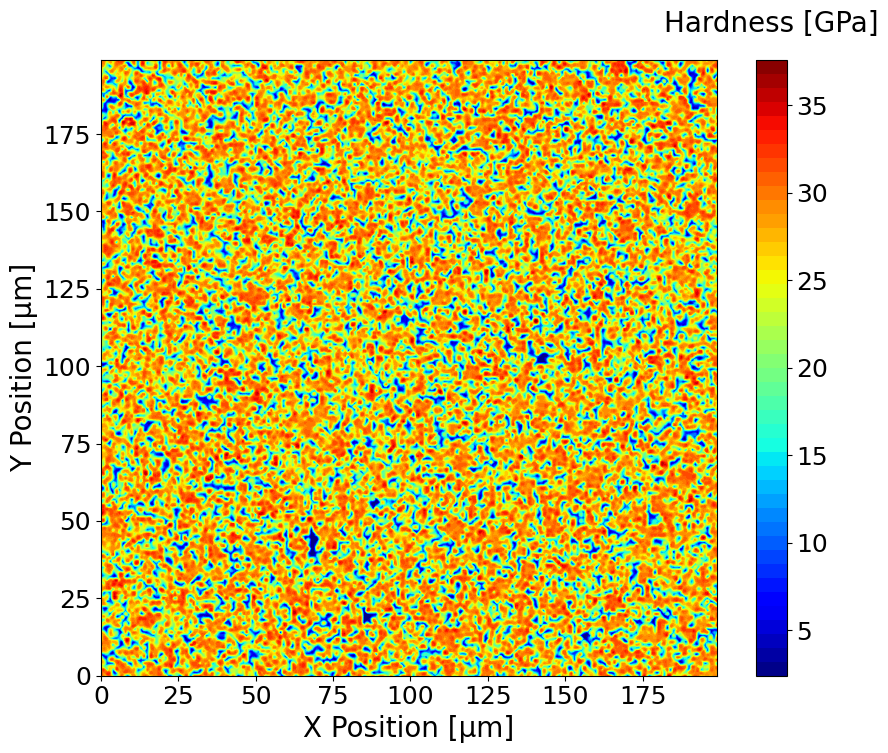

In [ ]:
import matplotlib.ticker as ticker
from scipy.interpolate import griddata
# Extract the X, Y, and Z values
X-pos = df['X'].values
Y-pos = df['Y'].values
Z1 = df['HARDNESS'].values
Z2 = df['MODULUS'].values
# Sort the X and Y values while keeping the corresponding Z values
sort_indices = np.lexsort((Y, X))
X_sorted = X[sort_indices]
Y_sorted = Y[sort_indices]
Z1_sorted = Z1[sort_indices]
Z2_sorted = Z2[sort_indices]
# Define the vmin and vmax values for each subplot
vmin1, vmax1 = 3, 45
vmin2, vmax2 = 150, 800
# Generate a regular grid of points
new_X, new_Y = np.meshgrid(np.linspace(X_sorted.min(), X-pos_sorted.max(), 500),
                           np.linspace(Y_sorted.min(), Y-pos_sorted.max(), 500))

# Interpolate the Z values on the regular grid using griddata
Z1_interp = griddata((X_sorted, Y_sorted), Z1_sorted, (new_X, new_Y), method='cubic')
Z2_interp = griddata((X_sorted, Y_sorted), Z2_sorted, (new_X, new_Y), method='cubic')


# Plot the first subplot
fig1 = plt.figure(figsize=(10, 8))
plt.gca().set_aspect('equal')
Z1_matrix_clipped = np.clip(Z1_interp, vmin1, vmax1)
levels = 50
im1 = plt.contourf(new_X, new_Y, Z1_matrix_clipped, cmap='jet', levels=levels)
plt.xlabel('X Position [μm]', fontsize= 20)
plt.ylabel('Y Position [μm]', fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=18)
cbar1 = fig1.colorbar(im1)
cbar1.ax.set_title('Hardness [GPa]', fontsize=20, pad=20)
cbar1.ax.yaxis.set_label_coords(-0.1, 0.5)
cbar1.ax.tick_params(labelsize=18)
# Set the colorbar tick labels to display every 5 units
from matplotlib.ticker import MultipleLocator
tick_spacing = 5
cbar1.ax.yaxis.set_major_locator(MultipleLocator(tick_spacing))



# Plot the second subplot
fig2 = plt.figure(figsize=(10, 8))
plt.gca().set_aspect('equal')
Z2_matrix_clipped = np.clip(Z2_interp, vmin2, vmax2)
levels = 45
im2 = plt.contourf(new_X, new_Y, Z2_matrix_clipped, cmap='jet', levels=levels)
plt.xlabel('X Position [μm]', fontsize= 20)
plt.ylabel('Y Position [μm]', fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=18)
cbar2 = fig2.colorbar(im2)
cbar2.ax.set_title('Modulus [GPa]', fontsize= 20, pad=20)
cbar2.ax.yaxis.set_label_coords(-0.1, 0.5)
cbar2.ax.tick_params(labelsize=18)
# Set the colorbar tick labels to display every 5 units
from matplotlib.ticker import MultipleLocator
tick_spacing = 50
cbar2.ax.yaxis.set_major_locator(MultipleLocator(tick_spacing))

# 2 cluster

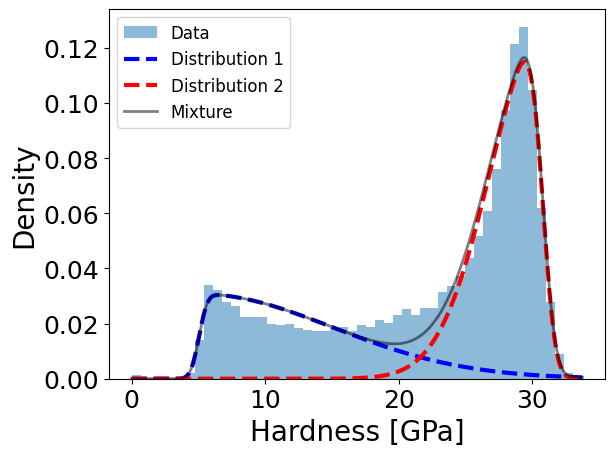

Parameter values Hardness:
w1: 0.39
w2: 0.61
loc1: 5.06
distancia (d): 25.74
scale1: 10.00
alpha1: 20.00
loc2: 30.80
scale2: 3.89
alpha2: -5.30


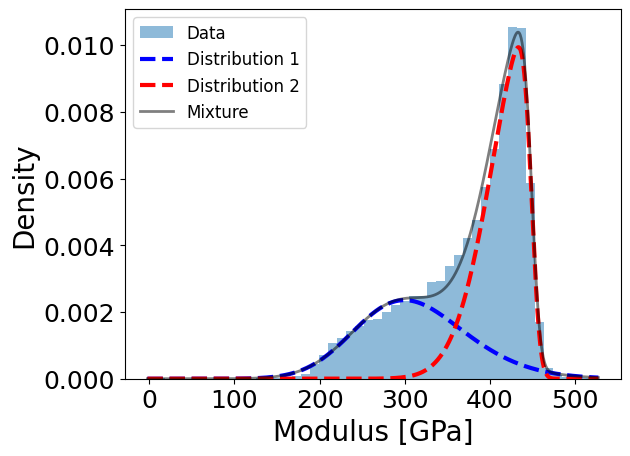

Parameter values MODULUS:
w1: 0.39
w2: 0.61
loc1: 250.00
distancia (d): 198.67
scale1: 91.28
alpha1: 1.62
loc2: 448.67
scale2: 45.43
alpha2: -5.78
AIC for hardness: -497.8720758691401
BIC for hardness: -484.48791483114303
AIC for modulus: -827.4325111788456
BIC for modulus: -815.9603731462768
Hardness Phase 1 - Mode: 15.05, Standard Deviation: 6.04
Hardness Phase 2 - Mode: 26.98, Standard Deviation: 2.41
Modulus Phase 1 - Mode: 327.67, Standard Deviation: 67.02
Modulus Phase 2 - Mode: 403.91, Standard Deviation: 28.07


In [35]:
from scipy.optimize import differential_evolution
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

# HARDNESS: Compute histogram and bin centers for hardness data
hist_hardness, bin_edges_hardness = np.histogram(X, bins=50, density=True)
bin_centers_hardness = (bin_edges_hardness[:-1] + bin_edges_hardness[1:]) / 2

# Define bounds for the differential evolution algorithm (Hardness)
bounds_hardness = [(0, b),             # w1 (weight)
                    (0, 10),            # loc1 (location)
                    (0.5, 100),         # d (distance between loc1 and loc2)
                    (0.1, 10),          # scale1 (spread for skew-normal 1)
                    (0, 20),         # alpha1 (skewness for skew-normal 1)
                    (0.1, 100),         # scale2 (spread for skew-normal 2)
                    (-20, 0)]        # alpha2 (skewness for skew-normal 2)

# Perform the optimization using differential evolution for HARDNESS
result_hardness = differential_evolution(
    error_function,
    bounds_hardness,
    args=(bin_centers_hardness, hist_hardness),
    maxiter=10000,        # Max number of iterations
    tol=1e-7,             # Tolerance for convergence
    popsize=30            # Population size (optional: larger value explores more)
)
params_hardness = result_hardness.x

loc2_hardness = params_hardness[1] + params_hardness[2]  # loc2 = loc1 + d (Hardness)
w2_hardness = 1 - params_hardness[0]  # w2 (second weight for mixture)

# Generate fitted skew-normal distributions for Hardness
x_hardness = np.linspace(np.min(X), np.max(X), 1000)
skew_normal_hardness_1 = skewnorm.pdf(x_hardness, params_hardness[4], loc=params_hardness[1], scale=params_hardness[3])
skew_normal_hardness_2 = skewnorm.pdf(x_hardness, params_hardness[6], loc=loc2_hardness, scale=params_hardness[5])

# Plot the histogram and fitted distributions (Hardness)
plt.hist(X, bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x_hardness, params_hardness[0] * skew_normal_hardness_1, 'b--', lw=3, alpha=1, label='Distribution 1')
plt.plot(x_hardness, w2_hardness * skew_normal_hardness_2, 'r--', lw=3, alpha=1, label='Distribution 2')

# Plot the mixture of skew-normal distributions
y_hardness = params_hardness[0] * skew_normal_hardness_1 + w2_hardness * skew_normal_hardness_2
plt.plot(x_hardness, y_hardness, 'k-', lw=2, alpha=0.5, label='Mixture')

# Labels and legend for Hardness
plt.xlabel('Hardness [GPa]', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=12)
plt.show()

# Print parameter values for HARDNESS
print("Parameter values Hardness:")
print("w1: {:.2f}".format(params_hardness[0]))
print("w2: {:.2f}".format(w2_hardness))
print("loc1: {:.2f}".format(params_hardness[1]))
print("distancia (d): {:.2f}".format(params_hardness[2]))
print("scale1: {:.2f}".format(params_hardness[3]))
print("alpha1: {:.2f}".format(params_hardness[4]))
print("loc2: {:.2f}".format(loc2_hardness))
print("scale2: {:.2f}".format(params_hardness[5]))
print("alpha2: {:.2f}".format(params_hardness[6]))

# MODULUS: Using the same weights from Hardness (w1 and w2 fixed)

# Compute histogram and bin centers for Modulus data
hist_modulus, bin_edges_modulus = np.histogram(Y, bins=50, density=True)
bin_centers_modulus = (bin_edges_modulus[:-1] + bin_edges_modulus[1:]) / 2

# Fix the weights (w1 and w2) from Hardness
w1_fixed = params_hardness[0]
w2_fixed = 1 - w1_fixed

# Define bounds for Modulus fitting (other parameters to be optimized)
bounds_modulus = [(0, 250),          # loc1 (location for Modulus)
                  (50, 1000),        # d (distance between loc1 and loc2)
                  (1, 1000),         # scale1 (spread for skew-normal 1)
                  (1, 20),        # alpha1 (skewness for skew-normal 1)
                  (1, 1000),         # scale2 (spread for skew-normal 2)
                  (-20, 0.1)]        # alpha2 (skewness for skew-normal 2)



# Perform the optimization for Modulus with fixed weights
result_modulus = differential_evolution(
    error_function_modulus,
    bounds_modulus,
    args=(bin_centers_modulus, hist_modulus),
    maxiter=10000,        # Max number of iterations
    tol=1e-7,             # Tolerance for convergence
    popsize=30            # Population size (optional: larger value explores more)
)
params_modulus = result_modulus.x

# Calculate loc2 for Modulus
loc2_modulus = params_modulus[0] + params_modulus[1]

# Generate fitted skew-normal distributions for Modulus
x_modulus = np.linspace(np.min(Y), np.max(Y), 1000)
skew_normal_modulus_1 = skewnorm.pdf(x_modulus, params_modulus[3], loc=params_modulus[0], scale=params_modulus[2])
skew_normal_modulus_2 = skewnorm.pdf(x_modulus, params_modulus[5], loc=loc2_modulus, scale=params_modulus[4])

# Plot the histogram and fitted distributions (Modulus)
plt.hist(Y, bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x_modulus, w1_fixed * skew_normal_modulus_1, 'b--', lw=3, alpha=1, label='Distribution 1')
plt.plot(x_modulus, w2_fixed * skew_normal_modulus_2, 'r--', lw=3, alpha=1, label='Distribution 2')

# Plot the mixture of skew-normal distributions for Modulus
y_modulus = w1_fixed * skew_normal_modulus_1 + w2_fixed * skew_normal_modulus_2
plt.plot(x_modulus, y_modulus, 'k-', lw=2, alpha=0.5, label='Mixture')

# Labels and legend for Modulus
plt.xlabel('Modulus [GPa]', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=12)
plt.show()

# Print parameter values for MODULUS
print("Parameter values MODULUS:")
print("w1: {:.2f}".format(w1_fixed))
print("w2: {:.2f}".format(w2_fixed))
print("loc1: {:.2f}".format(params_modulus[0]))
print("distancia (d): {:.2f}".format(params_modulus[1]))
print("scale1: {:.2f}".format(params_modulus[2]))
print("alpha1: {:.2f}".format(params_modulus[3]))
print("loc2: {:.2f}".format(loc2_modulus))
print("scale2: {:.2f}".format(params_modulus[4]))
print("alpha2: {:.2f}".format(params_modulus[5]))




# HARDNESS
# Calculate residuals for hardness
y_hardness_fit_at_bins = params_hardness[0] * skewnorm.pdf(bin_centers_hardness, params_hardness[4], loc=params_hardness[1], scale=params_hardness[3]) + \
                         w2_hardness * skewnorm.pdf(bin_centers_hardness, params_hardness[6], loc=params_hardness[1] + params_hardness[2], scale=params_hardness[5])

residuals_hardness = hist_hardness - y_hardness_fit_at_bins

# Number of data points and parameters for hardness
n_hardness = len(hist_hardness)  # Number of data points
k_hardness = 7  # Number of parameters in the hardness model (w1, loc1, d, scale1, alpha1, scale2, alpha2)

# Calculate AIC and BIC for hardness
aic_hardness_2phases, bic_hardness_2phases = calculate_aic_bic(n_hardness, k_hardness, residuals_hardness)

print(f"AIC for hardness: {aic_hardness_2phases}")
print(f"BIC for hardness: {bic_hardness_2phases}")

# MODULUS
# Calculate residuals for modulus
y_modulus_fit_at_bins = w1_fixed * skewnorm.pdf(bin_centers_modulus, params_modulus[3], loc=params_modulus[0], scale=params_modulus[2]) + \
                        w2_fixed * skewnorm.pdf(bin_centers_modulus, params_modulus[5], loc=params_modulus[0] + params_modulus[1], scale=params_modulus[4])

residuals_modulus = hist_modulus - y_modulus_fit_at_bins

# Number of data points and parameters for modulus
n_modulus = len(hist_modulus)  # Number of data points
k_modulus = 6  # Number of parameters in the modulus model (loc1, d, scale1, alpha1, scale2, alpha2)

# Calculate AIC and BIC for modulus
aic_modulus_2phases, bic_modulus_2phases = calculate_aic_bic(n_modulus, k_modulus, residuals_modulus)

print(f"AIC for modulus: {aic_modulus_2phases}")
print(f"BIC for modulus: {bic_modulus_2phases}")



#stats = calculate_skew_normal_stats_2(params_hardness, loc2_hardness, params_modulus, loc2_modulus)

# Print the results
#for phase, stat in stats.items():
#    print(f"{phase} - Mode: {stat['Mode']:.2f}, Standard Deviation: {stat['Standard Deviation']:.2f}")


Cluster 1: 37.04% of the data points
Cluster 2: 62.96% of the data points


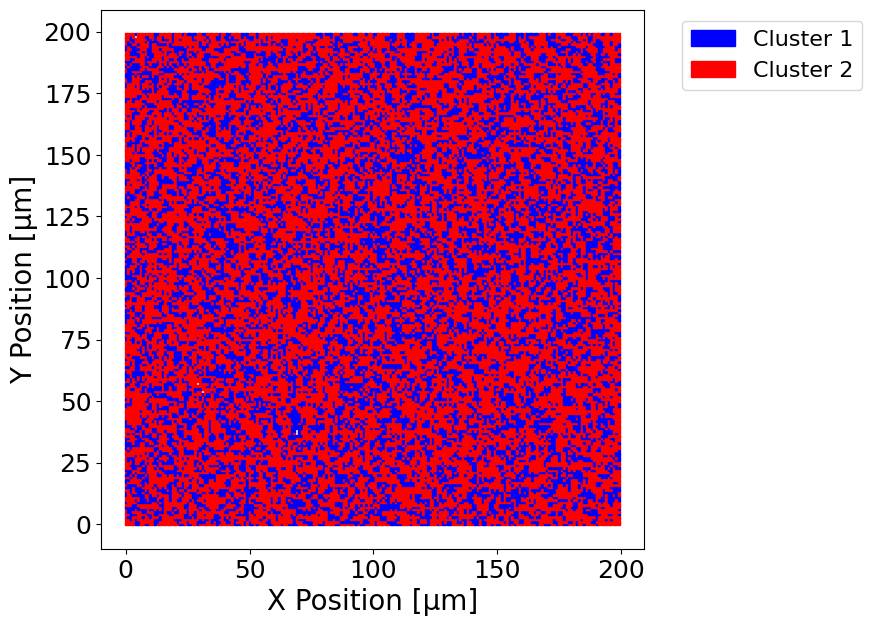

In [39]:
loc2_hardness = params_hardness[1] + params_hardness[2]  # loc2 = loc1 + d
loc2_modulus = params_modulus[0] + params_modulus[1]  # loc2 = loc1 + d for modulus
s= 2 # Size of the pixel
plot_clusters_2(X, Y, df, params_hardness, params_modulus, loc2_hardness, loc2_modulus, w1_fixed, w2_fixed)


# 3 clusters

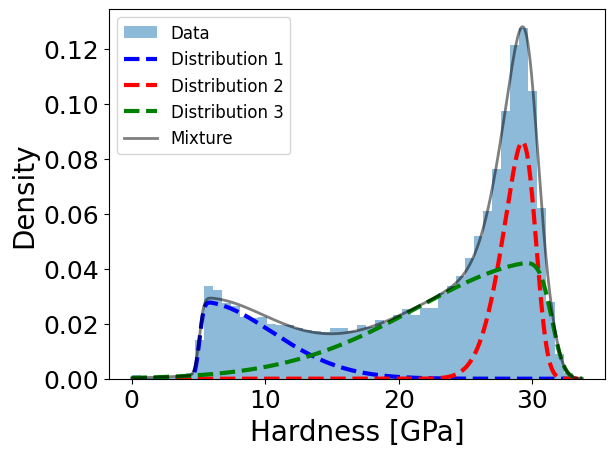

Parameter values Hardness:
w1: 0.19
w2: 0.27
w3: 0.54
loc1: 5.08
loc2: 30.24
loc3: 31.47
scale1: 5.42
alpha1: 20.00
scale2: 2.05
alpha2: -2.91
scale3: 10.00
alpha3: -13.76


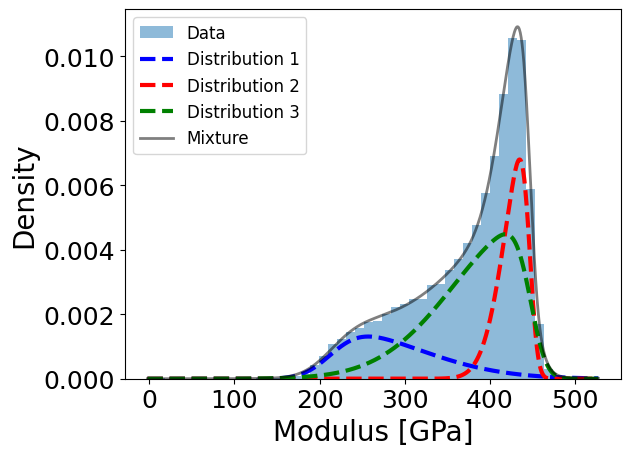

Parameter values Modulus:
w1: 0.19
w2: 0.27
w3: 0.54
loc1_mod: 213.52
loc2_mod: 446.44
loc3_mod: 447.44
scale1_mod: 100.00
alpha1_mod: 3.68
scale2_mod: 27.21
alpha2_mod: -3.63
scale3_mod: 88.84
alpha3_mod: -6.09
AIC for hardness: -622.5669983352564
BIC for hardness: -601.5347452755468
AIC for modulus: -945.9519572246247
BIC for modulus: -928.7437501757714
Hardness Phase 1 - Mode: 10.50, Standard Deviation: 3.28
Hardness Phase 2 - Mode: 28.30, Standard Deviation: 1.35
Hardness Phase 3 - Mode: 21.50, Standard Deviation: 6.06
Modulus Phase 1 - Mode: 310.03, Standard Deviation: 63.80
Modulus Phase 2 - Mode: 420.21, Standard Deviation: 17.39
Modulus Phase 3 - Mode: 359.77, Standard Deviation: 54.78


In [46]:

# HARDNESS

hist, bin_edges = np.histogram(X, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Define the bounds for the parameters (3 phases)
# Bounds for: w1, w3, loc1, d1, d2, scale1, alpha1, scale2, alpha2, scale3, alpha3
bounds = [
    (0, b),             # w1 (weight for phase 1)
    (0, 1),             # w3 (weight for phase 3)
    (0, 10),            # loc1 (location of phase 1)
    (0.5, 100),         # d1 (distance between loc1 and loc2)
    (0.5, 100),         # d2 (distance between loc2 and loc3)
    (0.1, 10),          # scale1 (spread for phase 1)
    (-100, 20),         # alpha1 (skewness for phase 1)
    (0.1, 10),          # scale2 (spread for phase 2)
    (-100, 20),         # alpha2 (skewness for phase 2)
    (0.1, 10),          # scale3 (spread for phase 3)
    (-100, 20)          # alpha3 (skewness for phase 3)
]

# Perform the optimization using differential evolution for HARDNESS
result = differential_evolution(
    error_function_3phases,
    bounds,
    args=(bin_centers, hist),
    maxiter=5000,        # Max number of iterations
    tol=1e-7,             # Tolerance for convergence
    popsize=15            # Population size (optional: larger value explores more)
)

# Extract optimized parameters
params_hardness = result.x

# Calculate w2 (since w1 + w2 + w3 = 1)
w1 = params_hardness[0]
w3 = params_hardness[1]
w2 = 1 - (w1 + w3)

# Calculate loc2 and loc3 based on the distances
loc1 = params_hardness[2]
loc2 = loc1 + params_hardness[3]
loc3 = loc2 + params_hardness[4]

# Generate fitted skew-normal distributions for the 3 phases
x = np.linspace(np.min(X), np.max(X), 1000)
skew_normal_1 = skewnorm.pdf(x, params_hardness[6], loc=loc1, scale=params_hardness[5])
skew_normal_2 = skewnorm.pdf(x, params_hardness[8], loc=loc2, scale=params_hardness[7])
skew_normal_3 = skewnorm.pdf(x, params_hardness[10], loc=loc3, scale=params_hardness[9])

# Plot the histogram and fitted distributions (Hardness)
plt.hist(X, bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x, w1 * skew_normal_1, 'b--', lw=3, alpha=1, label='Distribution 1')
plt.plot(x, w2 * skew_normal_2, 'r--', lw=3, alpha=1, label='Distribution 2')
plt.plot(x, w3 * skew_normal_3, 'g--', lw=3, alpha=1, label='Distribution 3')

# Plot the mixture of skew-normal distributions
y = w1 * skew_normal_1 + w2 * skew_normal_2 + w3 * skew_normal_3
plt.plot(x, y, 'k-', lw=2, alpha=0.5, label='Mixture')

# Labels and legend for Hardness
plt.xlabel('Hardness [GPa]', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=12)
plt.show()

# Print parameter values for hardness
print("Parameter values Hardness:")
print(f"w1: {w1:.2f}")
print(f"w2: {w2:.2f}")
print(f"w3: {w3:.2f}")
print(f"loc1: {loc1:.2f}")
print(f"loc2: {loc2:.2f}")
print(f"loc3: {loc3:.2f}")
print(f"scale1: {params_hardness[5]:.2f}")
print(f"alpha1: {params_hardness[6]:.2f}")
print(f"scale2: {params_hardness[7]:.2f}")
print(f"alpha2: {params_hardness[8]:.2f}")
print(f"scale3: {params_hardness[9]:.2f}")
print(f"alpha3: {params_hardness[10]:.2f}")


# MODULUS

# Histograma para el Modulus
hist_modulus, bin_edges_modulus = np.histogram(Y, bins=50, density=True)
bin_centers_modulus = (bin_edges_modulus[:-1] + bin_edges_modulus[1:]) / 2

# Define the error function for Modulus with fixed w1, w2, w3 from Hardness
def error_function_modulus(params_mod, bin_centers_mod, hist_mod):
    # Extract parameters from the params_mod array
    loc1_mod, d1_mod, d2_mod, scale1_mod, alpha1_mod, scale2_mod, alpha2_mod, scale3_mod, alpha3_mod = params_mod

    # Calculate loc2_mod and loc3_mod ensuring the distance constraints
    loc2_mod = loc1_mod + d1_mod
    loc3_mod = loc2_mod + d2_mod

    # Generate the skew-normal distributions for Modulus
    dist1_mod = skewnorm.pdf(bin_centers_mod, alpha1_mod, loc=loc1_mod, scale=scale1_mod)
    dist2_mod = skewnorm.pdf(bin_centers_mod, alpha2_mod, loc=loc2_mod, scale=scale2_mod)
    dist3_mod = skewnorm.pdf(bin_centers_mod, alpha3_mod, loc=loc3_mod, scale=scale3_mod)

    # Weighted sum of the three distributions (weights w1, w2, w3 are fixed from Hardness)
    y_fit_mod = w1 * dist1_mod + w2 * dist2_mod + w3 * dist3_mod

    # Calculate the error (sum of squared differences)
    return np.sum((hist_mod - y_fit_mod) ** 2)

# Bounds for Modulus optimization (without optimizing w1, w2, w3)
# Bounds for: loc1_mod, d1_mod, d2_mod, scale1_mod, alpha1_mod, scale2_mod, alpha2_mod, scale3_mod, alpha3_mod
bounds_modulus = [
    (150, 300),         # loc1_mod (location of phase 1 for Modulus)
    (50, 1000),       # d1_mod (distance between loc1_mod and loc2_mod)
    (1, 10),       # d2_mod (distance between loc2_mod and loc3_mod)
    (0.1, 100),       # scale1_mod (spread for phase 1 for Modulus)
    (-100, 20),       # alpha1_mod (skewness for phase 1 for Modulus)
    (0.1, 300),       # scale2_mod (spread for phase 2 for Modulus)
    (-300, 20),       # alpha2_mod (skewness for phase 2 for Modulus)
    (0.1, 300),       # scale3_mod (spread for phase 3 for Modulus)
    (-300, 20)        # alpha3_mod (skewness for phase 3 for Modulus)
]

# Perform the optimization using differential evolution for Modulus
result_modulus = differential_evolution(
    error_function_modulus,
    bounds_modulus,
    args=(bin_centers_modulus, hist_modulus),
    maxiter=10000,        # Max number of iterations
    tol=1e-7,             # Tolerance for convergence
    popsize=30            # Population size (optional: larger value explores more)
)

# Extract optimized parameters for Modulus
params_modulus = result_modulus.x

# Calculate loc2_mod and loc3_mod based on the distances
loc1_mod = params_modulus[0]
loc2_mod = loc1_mod + params_modulus[1]
loc3_mod = loc2_mod + params_modulus[2]

# Generate fitted skew-normal distributions for the 3 phases (Modulus)
x_mod = np.linspace(np.min(Y), np.max(Y), 1000)
skew_normal_1_mod = skewnorm.pdf(x_mod, params_modulus[4], loc=loc1_mod, scale=params_modulus[3])
skew_normal_2_mod = skewnorm.pdf(x_mod, params_modulus[6], loc=loc2_mod, scale=params_modulus[5])
skew_normal_3_mod = skewnorm.pdf(x_mod, params_modulus[8], loc=loc3_mod, scale=params_modulus[7])

# Plot the histogram and fitted distributions (Modulus)
plt.hist(Y, bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x_mod, w1 * skew_normal_1_mod, 'b--', lw=3, alpha=1, label='Distribution 1')
plt.plot(x_mod, w2 * skew_normal_2_mod, 'r--', lw=3, alpha=1, label='Distribution 2')
plt.plot(x_mod, w3 * skew_normal_3_mod, 'g--', lw=3, alpha=1, label='Distribution 3')

# Plot the mixture of skew-normal distributions for Modulus
y_modulus = w1 * skew_normal_1_mod + w2 * skew_normal_2_mod + w3 * skew_normal_3_mod
plt.plot(x_mod, y_modulus, 'k-', lw=2, alpha=0.5, label='Mixture')

# Labels and legend for Modulus
plt.xlabel('Modulus [GPa]', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=12)
plt.show()

# Print parameter values for Modulus
print("Parameter values Modulus:")
print(f"w1: {w1:.2f}")
print(f"w2: {w2:.2f}")
print(f"w3: {w3:.2f}")
print(f"loc1_mod: {loc1_mod:.2f}")
print(f"loc2_mod: {loc2_mod:.2f}")
print(f"loc3_mod: {loc3_mod:.2f}")
print(f"scale1_mod: {params_modulus[3]:.2f}")
print(f"alpha1_mod: {params_modulus[4]:.2f}")
print(f"scale2_mod: {params_modulus[5]:.2f}")
print(f"alpha2_mod: {params_modulus[6]:.2f}")
print(f"scale3_mod: {params_modulus[7]:.2f}")
print(f"alpha3_mod: {params_modulus[8]:.2f}")

import numpy as np

# Function to calculate AIC and BIC
def calculate_aic_bic(n, k, residuals):
    rss = np.sum(residuals ** 2)  # Residual sum of squares
    aic = 2 * k + n * np.log(rss / n)
    bic = k * np.log(n) + n * np.log(rss / n)
    return aic, bic

# HARDNESS: Calculate residuals for 3-phase hardness model
y_hardness_fit_at_bins = (
    w1 * skewnorm.pdf(bin_centers, params[6], loc=params[2], scale=params[5]) +
    w2 * skewnorm.pdf(bin_centers, params[8], loc=params[2] + params[3], scale=params[7]) +
    w3 * skewnorm.pdf(bin_centers, params[10], loc=params[2] + params[3] + params[4], scale=params[9])
)

# Calculate residuals (histogram minus fitted values)
residuals_hardness = hist - y_hardness_fit_at_bins

# Number of data points and parameters for hardness
n_hardness = len(hist)  # Number of data points
k_hardness = 11  # Number of parameters in the hardness model (w1, w3, loc1, d1, d2, scale1, alpha1, scale2, alpha2, scale3, alpha3)

# Calculate AIC and BIC for hardness
aic_hardness_3phases, bic_hardness_3phases = calculate_aic_bic(n_hardness, k_hardness, residuals_hardness)

print(f"AIC for hardness: {aic_hardness_3phases}")
print(f"BIC for hardness: {bic_hardness_3phases}")

# MODULUS: Calculate residuals for 3-phase modulus model
y_modulus_fit_at_bins = (
    w1 * skewnorm.pdf(bin_centers_modulus, params_modulus[4], loc=params_modulus[0], scale=params_modulus[3]) +
    w2 * skewnorm.pdf(bin_centers_modulus, params_modulus[6], loc=params_modulus[0] + params_modulus[1], scale=params_modulus[5]) +
    w3 * skewnorm.pdf(bin_centers_modulus, params_modulus[8], loc=params_modulus[0] + params_modulus[1] + params_modulus[2], scale=params_modulus[7])
)

# Calculate residuals (histogram minus fitted values)
residuals_modulus = hist_modulus - y_modulus_fit_at_bins

# Number of data points and parameters for modulus
n_modulus = len(hist_modulus)  # Number of data points
k_modulus = 9  # Number of parameters in the modulus model (loc1_mod, d1_mod, d2_mod, scale1_mod, alpha1_mod, scale2_mod, alpha2_mod, scale3_mod, alpha3_mod)

# Calculate AIC and BIC for modulus
aic_modulus_3phases, bic_modulus_3phases = calculate_aic_bic(n_modulus, k_modulus, residuals_modulus)

print(f"AIC for modulus: {aic_modulus_3phases}")
print(f"BIC for modulus: {bic_modulus_3phases}")


loc2_hardness = params_hardness[2] + params_hardness[3]  # loc2 = loc1 + d1
loc3_hardness = loc2_hardness + params_hardness[4]       # loc3 = loc2 + d2
loc2_modulus = params_modulus[0] + params_modulus[1]  # loc2 = loc1 + d1 for modulus
loc3_modulus = loc2_modulus + params_modulus[2]       # loc3 = loc2 + d2 for modulus

# Calculate statistics
# stats = calculate_skew_normal_stats_3phases(params_hardness, loc2_hardness, loc3_hardness, params_modulus, loc2_modulus, loc3_modulus)

# Print the results
# for phase, stat in stats.items():
#    print(f"{phase} - Mode: {stat['Mode']:.2f}, Standard Deviation: {stat['Standard Deviation']:.2f}")

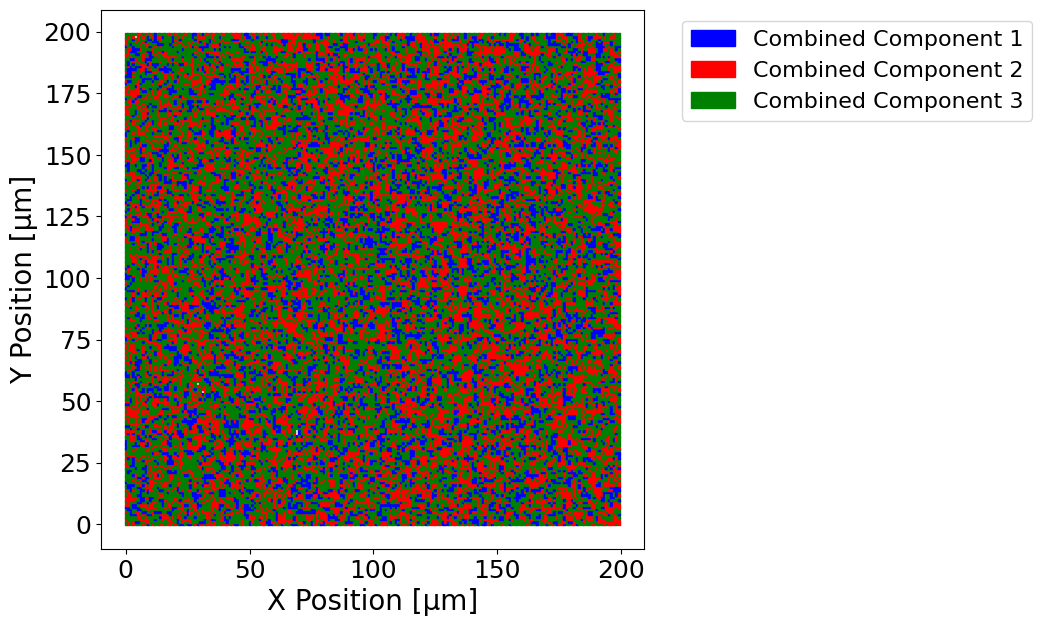

Cluster 1: 17.90% of the data points
Cluster 2: 30.89% of the data points
Cluster 3: 51.21% of the data points


In [49]:
s=2 # Size of the pixel
colors = ['blue', 'red', 'green']
plot_clusters_3phases(X, Y, params_hardness, params_modulus, loc1, loc2, loc3, loc1_mod, loc2_mod, loc3_mod, w1, w2, w3, df, colors)

## 3 clusters: 2 and 3 with same loc

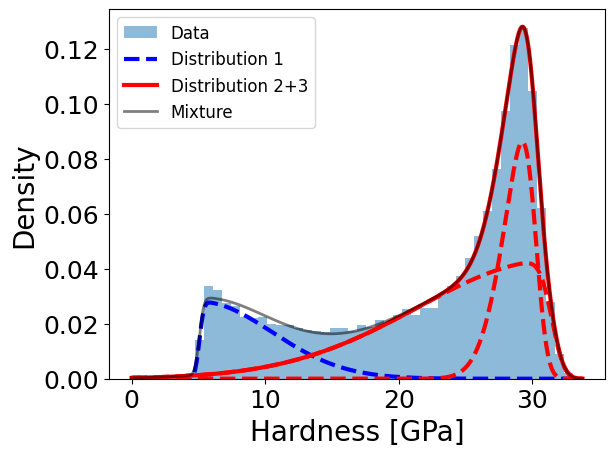

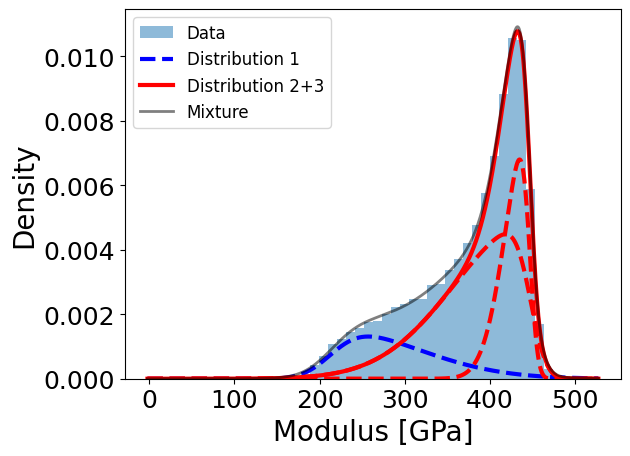

Parameter values Hardness:
w1: 0.19
w2: 0.27
w3: 0.54
loc1: 5.08
loc2: 30.24
loc3: 31.47
scale1: 5.42
alpha1: 20.00
scale2: 2.05
alpha2: -2.91
scale3: 10.00
alpha3: -13.76

Combined Distribution 2+3:
Combined weight: 0.81
Combined location: 31.06
Combined scale: 7.35
Combined skewness (alpha): -10.14

Parameter values Modulus:
w1: 0.19
w2: 0.27
w3: 0.54
loc1_mod: 213.52
loc2_mod: 446.44
loc3_mod: 447.44
scale1_mod: 100.00
alpha1_mod: 3.68
scale2_mod: 27.21
alpha2_mod: -3.63
scale3_mod: 88.84
alpha3_mod: -6.09

Combined Modulus Distribution 2+3:
Combined weight: 0.81
Combined location: 447.11
Combined scale: 68.26
Combined skewness (alpha): -5.26


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

# HARDNESS

# Generate fitted skew-normal distributions for the 3 phases
x = np.linspace(np.min(X), np.max(X), 1000)
skew_normal_1 = skewnorm.pdf(x, params_hardness[6], loc=loc1, scale=params_hardness[5])
skew_normal_2 = skewnorm.pdf(x, params_hardness[8], loc=loc2, scale=params_hardness[7])
skew_normal_3 = skewnorm.pdf(x, params_hardness[10], loc=loc3, scale=params_hardness[9])

# Sum of the 2nd and 3rd phase distributions
skew_normal_23 = w2 * skew_normal_2 + w3 * skew_normal_3

# Plot the histogram and fitted distributions (Hardness)
plt.hist(X, bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x, w1 * skew_normal_1, 'b--', lw=3, alpha=1, label='Distribution 1')
plt.plot(x, w2 * skew_normal_2, 'r--', lw=3, alpha=1)
plt.plot(x, w3 * skew_normal_3, 'r--', lw=3, alpha=1)
plt.plot(x, skew_normal_23, 'r-', lw=3, alpha=1, label='Distribution 2+3')

# Plot the mixture of skew-normal distributions
y = w1 * skew_normal_1 + w2 * skew_normal_2 + w3 * skew_normal_3
plt.plot(x, y, 'k-', lw=2, alpha=0.5, label='Mixture')

# Labels and legend for Hardness
plt.xlabel('Hardness [GPa]', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=12)
plt.show()

# MODULUS

# Generate fitted skew-normal distributions for the 3 phases (Modulus)
x_mod = np.linspace(np.min(Y), np.max(Y), 1000)
skew_normal_1_mod = skewnorm.pdf(x_mod, params_modulus[4], loc=loc1_mod, scale=params_modulus[3])
skew_normal_2_mod = skewnorm.pdf(x_mod, params_modulus[6], loc=loc2_mod, scale=params_modulus[5])
skew_normal_3_mod = skewnorm.pdf(x_mod, params_modulus[8], loc=loc3_mod, scale=params_modulus[7])

# Sum of the 2nd and 3rd phase distributions
skew_normal_23_mod = (w2 * skew_normal_2_mod) + (w3 * skew_normal_3_mod)

# Plot the histogram and fitted distributions (Modulus)
plt.hist(Y, bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x_mod, w1 * skew_normal_1_mod, 'b--', lw=3, alpha=1, label='Distribution 1')
plt.plot(x_mod, w2 * skew_normal_2_mod, 'r--', lw=3, alpha=1)
plt.plot(x_mod, w3 * skew_normal_3_mod, 'r--', lw=3, alpha=1)
plt.plot(x_mod, skew_normal_23_mod, 'r-', lw=3, alpha=1, label='Distribution 2+3')

# Plot the mixture of skew-normal distributions for Modulus
y_modulus = w1 * skew_normal_1_mod + w2 * skew_normal_2_mod + w3 * skew_normal_3_mod
plt.plot(x_mod, y_modulus, 'k-', lw=2, alpha=0.5, label='Mixture')

# Labels and legend for Modulus
plt.xlabel('Modulus [GPa]', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=12)
plt.show()

# Extract parameters for the combined distribution (2+3)
combined_weight = w2 + w3
combined_loc = (w2 * loc2 + w3 * loc3) / combined_weight
combined_scale = (w2 * params_hardness[7] + w3 * params_hardness[9]) / combined_weight
combined_alpha = (w2 * params_hardness[8] + w3 * params_hardness[10]) / combined_weight

# Print parameter values for hardness and combined 2+3
print("Parameter values Hardness:")
print(f"w1: {w1:.2f}")
print(f"w2: {w2:.2f}")
print(f"w3: {w3:.2f}")
print(f"loc1: {loc1:.2f}")
print(f"loc2: {loc2:.2f}")
print(f"loc3: {loc3:.2f}")
print(f"scale1: {params_hardness[5]:.2f}")
print(f"alpha1: {params_hardness[6]:.2f}")
print(f"scale2: {params_hardness[7]:.2f}")
print(f"alpha2: {params_hardness[8]:.2f}")
print(f"scale3: {params_hardness[9]:.2f}")
print(f"alpha3: {params_hardness[10]:.2f}")

print("\nCombined Distribution 2+3:")
print(f"Combined weight: {combined_weight:.2f}")
print(f"Combined location: {combined_loc:.2f}")
print(f"Combined scale: {combined_scale:.2f}")
print(f"Combined skewness (alpha): {combined_alpha:.2f}")

# For modulus, do the same calculation
combined_weight_mod = w2 + w3
combined_loc_mod = (w2 * loc2_mod + w3 * loc3_mod) / combined_weight_mod
combined_scale_mod = (w2 * params_modulus[5] + w3 * params_modulus[7]) / combined_weight_mod
combined_alpha_mod = (w2 * params_modulus[6] + w3 * params_modulus[8]) / combined_weight_mod

# Print parameter values for Modulus and combined 2+3 Modulus
print("\nParameter values Modulus:")
print(f"w1: {w1:.2f}")
print(f"w2: {w2:.2f}")
print(f"w3: {w3:.2f}")
print(f"loc1_mod: {loc1_mod:.2f}")
print(f"loc2_mod: {loc2_mod:.2f}")
print(f"loc3_mod: {loc3_mod:.2f}")
print(f"scale1_mod: {params_modulus[3]:.2f}")
print(f"alpha1_mod: {params_modulus[4]:.2f}")
print(f"scale2_mod: {params_modulus[5]:.2f}")
print(f"alpha2_mod: {params_modulus[6]:.2f}")
print(f"scale3_mod: {params_modulus[7]:.2f}")
print(f"alpha3_mod: {params_modulus[8]:.2f}")

print("\nCombined Modulus Distribution 2+3:")
print(f"Combined weight: {combined_weight_mod:.2f}")
print(f"Combined location: {combined_loc_mod:.2f}")
print(f"Combined scale: {combined_scale_mod:.2f}")
print(f"Combined skewness (alpha): {combined_alpha_mod:.2f}")

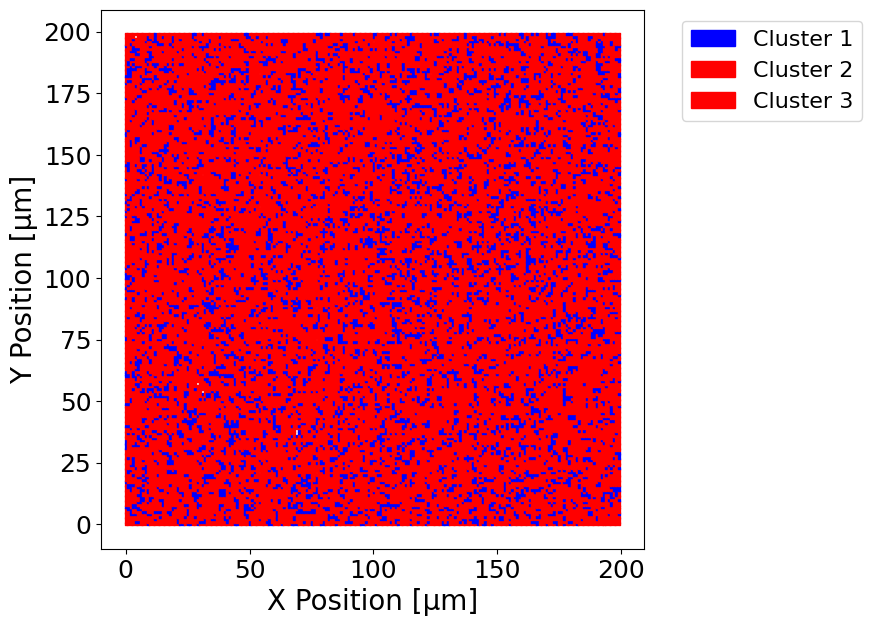

Cluster 1: 17.90% of the data points
Cluster 2: 30.89% of the data points
Cluster 3: 51.21% of the data points


In [57]:
s=2 # Size of the pixel
colors = ['blue', 'red', 'red']
plot_clusters_3phases(X, Y, params_hardness, params_modulus, loc1, loc2, loc3, loc1_mod, loc2_mod, loc3_mod, w1, w2, w3, df, colors)

# 4 clusters

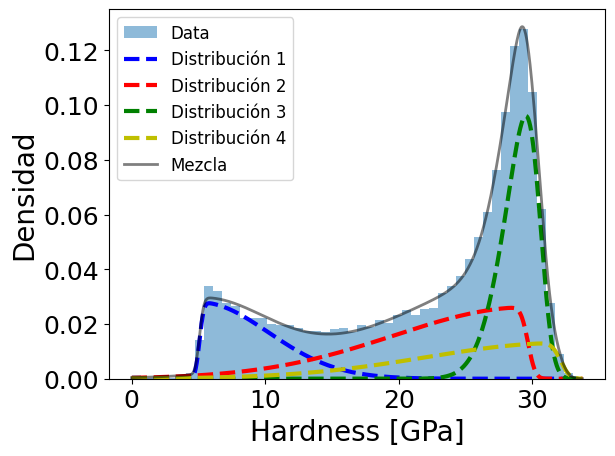

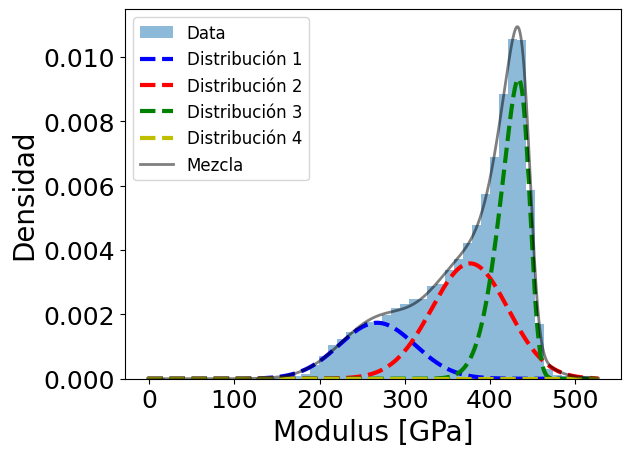

AIC para Hardness: -620.546820140375
BIC para Hardness: -593.7784980643809
AIC para Modulus: -913.5529405712373
BIC para Modulus: -886.7846184952432
BIC para Modulus: -691.1631234384336


In [24]:
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Definimos la mezcla de 4 distribuciones skew-normal
def mixture_skew_normal_4(x, loc1, d1, d2, d3, scale1, alpha1, scale2, alpha2, scale3, alpha3, scale4, alpha4):
    # Calculamos las ubicaciones de las fases
    loc2 = loc1 + d1
    loc3 = loc2 + d2
    loc4 = loc3 + d3

    # Calculamos las distribuciones skew-normal
    dist1 = skewnorm.pdf(x, alpha1, loc=loc1, scale=scale1)
    dist2 = skewnorm.pdf(x, alpha2, loc=loc2, scale=scale2)
    dist3 = skewnorm.pdf(x, alpha3, loc=loc3, scale=scale3)
    dist4 = skewnorm.pdf(x, alpha4, loc=loc4, scale=scale4)

    return dist1, dist2, dist3, dist4

# Función de error para 4 fases
def error_function_4phases(params, bin_centers, hist):
    w1, w4, loc1, d1, d2, d3, scale1, alpha1, scale2, alpha2, scale3, alpha3, scale4, alpha4 = params

    # Calculamos w2 y w3 de manera que w1 + w2 + w3 + w4 = 1
    w2 = (1 - (w1 + w4)) / 2
    w3 = w2

    # Obtenemos las distribuciones
    dist1, dist2, dist3, dist4 = mixture_skew_normal_4(bin_centers, loc1, d1, d2, d3, scale1, alpha1, scale2, alpha2, scale3, alpha3, scale4, alpha4)

    # Suma ponderada de las 4 distribuciones
    y_fit = w1 * dist1 + w2 * dist2 + w3 * dist3 + w4 * dist4

    # Devolvemos la suma de las diferencias cuadradas
    return np.sum((hist - y_fit) ** 2)

# Histogramas y cálculo de los centros de los bins para Hardness
hist_hardness, bin_edges_hardness = np.histogram(X, bins=50, density=True)
bin_centers_hardness = (bin_edges_hardness[:-1] + bin_edges_hardness[1:]) / 2

# Definimos los límites para la optimización de las 4 fases (Hardness)
bounds_4phases_hardness = [
    (0, 1),     # w1 (peso de la fase 1)
    (0, 1),     # w4 (peso de la fase 4)
    (0, 10),    # loc1 (ubicación de la fase 1)
    (0.5, 100), # d1 (distancia entre loc1 y loc2)
    (0.5, 100), # d2 (distancia entre loc2 y loc3)
    (0.5, 100), # d3 (distancia entre loc3 y loc4)
    (0.1, 10),          # scale1 (spread for phase 1)
    (-100, 20),         # alpha1 (skewness for phase 1)
    (0.1, 10),          # scale2 (spread for phase 2)
    (-100, 20),         # alpha2 (skewness for phase 2)
    (0.1, 10),          # scale3 (spread for phase 3)
    (-100, 20),          # alpha3 (skewness for phase 3)
    (0.1, 10),  # scale4 (dispersión para la fase 4)
    (-100, 20)  # alpha4 (asimetría para la fase 4)
]

# Realizamos la optimización usando differential evolution para Hardness
result_hardness = differential_evolution(
    error_function_4phases,
    bounds_4phases_hardness,
    args=(bin_centers_hardness, hist_hardness),
    maxiter=1000,
    tol=1e-7,
    popsize=15
)

# Extraemos los parámetros optimizados para Hardness
params_hardness = result_hardness.x
w1, w4 = params_hardness[0], params_hardness[1]
w2 = (1 - (w1 + w4)) / 2
w3 = w2

# Calculamos las ubicaciones de las fases para Hardness
loc1_hardness = params_hardness[2]
loc2_hardness = loc1_hardness + params_hardness[3]
loc3_hardness = loc2_hardness + params_hardness[4]
loc4_hardness = loc3_hardness + params_hardness[5]

# Generamos las distribuciones skew-normal ajustadas para Hardness
x_hardness = np.linspace(np.min(X), np.max(X), 1000)
skew_normal_1_hardness, skew_normal_2_hardness, skew_normal_3_hardness, skew_normal_4_hardness = mixture_skew_normal_4(
    x_hardness, loc1_hardness, params_hardness[3], params_hardness[4], params_hardness[5],
    params_hardness[6], params_hardness[7], params_hardness[8], params_hardness[9],
    params_hardness[10], params_hardness[11], params_hardness[12], params_hardness[13])

# Gráfico para Hardness
plt.hist(X, bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x_hardness, w1 * skew_normal_1_hardness, 'b--', lw=3, alpha=1, label='Distribución 1')
plt.plot(x_hardness, w2 * skew_normal_2_hardness, 'r--', lw=3, alpha=1, label='Distribución 2')
plt.plot(x_hardness, w3 * skew_normal_3_hardness, 'g--', lw=3, alpha=1, label='Distribución 3')
plt.plot(x_hardness, w4 * skew_normal_4_hardness, 'y--', lw=3, alpha=1, label='Distribución 4')
plt.plot(x_hardness, (w1 * skew_normal_1_hardness + w2 * skew_normal_2_hardness + w3 * skew_normal_3_hardness + w4 * skew_normal_4_hardness), 'k-', lw=2, alpha=0.5, label='Mezcla')
plt.xlabel('Hardness [GPa]', fontsize=20)
plt.ylabel('Densidad', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=12)
plt.show()

# Ahora, ajustamos Modulus de manera similar
def error_function_modulus_4phases(params_mod, bin_centers_mod, hist_mod):
    w1, w4, loc1, d1, d2, d3, scale1, alpha1, scale2, alpha2, scale3, alpha3, scale4, alpha4 = params_mod

    # Calculamos w2 y w3 de manera que w1 + w2 + w3 + w4 = 1
    w2 = (1 - (w1 + w4)) / 2
    w3 = w2

    # Obtenemos las distribuciones para Modulus
    dist1, dist2, dist3, dist4 = mixture_skew_normal_4(bin_centers_mod, loc1, d1, d2, d3, scale1, alpha1, scale2, alpha2, scale3, alpha3, scale4, alpha4)

    # Suma ponderada de las 4 distribuciones
    y_fit_mod = w1 * dist1 + w2 * dist2 + w3 * dist3 + w4 * dist4

    # Devolvemos la suma de las diferencias cuadradas
    return np.sum((hist_mod - y_fit_mod) ** 2)

# Definimos los límites para la optimización de las 4 fases (Modulus)
bounds_4phases_modulus = [
    (0, 1),      # w1 (peso de la fase 1)
    (0, 1),      # w4 (peso de la fase 4)
    (0, 300),    # loc1 (ubicación de la fase 1)
    (50, 1000),  # d1 (distancia entre loc1 y loc2)
    (50, 1000),  # d2 (distancia entre loc2 y loc3)
    (50, 1000),  # d3 (distancia entre loc3 y loc4)
    (0.1, 100),  # scale1 (dispersión para la fase 1)
    (-100, 20),  # alpha1 (asimetría para la fase 1)
    (0.1, 100),  # scale2 (dispersión para la fase 2)
    (-100, 20),  # alpha2 (asimetría para la fase 2)
    (0.1, 100),  # scale3 (dispersión para la fase 3)
    (-100, 20),  # alpha3 (asimetría para la fase 3)
    (0.1, 100),  # scale4 (dispersión para la fase 4)
    (-100, 20)   # alpha4 (asimetría para la fase 4)
]

# Realizamos la optimización usando differential evolution para Modulus
result_modulus = differential_evolution(
    error_function_modulus_4phases,
    bounds_4phases_modulus,
    args=(bin_centers_modulus, hist_modulus),
    maxiter=1000,
    tol=1e-7,
    popsize=15
)

# Extraemos los parámetros optimizados para Modulus
params_modulus = result_modulus.x
w1_mod, w4_mod = params_modulus[0], params_modulus[1]
w2_mod = (1 - (w1_mod + w4_mod)) / 2
w3_mod = w2_mod

# Calculamos las ubicaciones de las fases para Modulus
loc1_modulus = params_modulus[2]
loc2_modulus = loc1_modulus + params_modulus[3]
loc3_modulus = loc2_modulus + params_modulus[4]
loc4_modulus = loc3_modulus + params_modulus[5]

# Generamos las distribuciones skew-normal ajustadas para Modulus
x_modulus = np.linspace(np.min(Y), np.max(Y), 1000)
skew_normal_1_modulus, skew_normal_2_modulus, skew_normal_3_modulus, skew_normal_4_modulus = mixture_skew_normal_4(
    x_modulus, loc1_modulus, params_modulus[3], params_modulus[4], params_modulus[5],
    params_modulus[6], params_modulus[7], params_modulus[8], params_modulus[9],
    params_modulus[10], params_modulus[11], params_modulus[12], params_modulus[13])

# Gráfico para Modulus
plt.hist(Y, bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x_modulus, w1_mod * skew_normal_1_modulus, 'b--', lw=3, alpha=1, label='Distribución 1')
plt.plot(x_modulus, w2_mod * skew_normal_2_modulus, 'r--', lw=3, alpha=1, label='Distribución 2')
plt.plot(x_modulus, w3_mod * skew_normal_3_modulus, 'g--', lw=3, alpha=1, label='Distribución 3')
plt.plot(x_modulus, w4_mod * skew_normal_4_modulus, 'y--', lw=3, alpha=1, label='Distribución 4')
plt.plot(x_modulus, (w1_mod * skew_normal_1_modulus + w2_mod * skew_normal_2_modulus + w3_mod * skew_normal_3_modulus + w4_mod * skew_normal_4_modulus), 'k-', lw=2, alpha=0.5, label='Mezcla')
plt.xlabel('Modulus [GPa]', fontsize=20)
plt.ylabel('Densidad', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=12)
plt.show()

# Evaluate y_fit_hardness at bin_centers_hardness to match hist_hardness shape
y_fit_hardness_at_bins = (w1 * skewnorm.pdf(bin_centers_hardness, params_hardness[7], loc=loc1_hardness, scale=params_hardness[6]) +
                          w2 * skewnorm.pdf(bin_centers_hardness, params_hardness[9], loc=loc2_hardness, scale=params_hardness[8]) +
                          w3 * skewnorm.pdf(bin_centers_hardness, params_hardness[11], loc=loc3_hardness, scale=params_hardness[10]) +
                          w4 * skewnorm.pdf(bin_centers_hardness, params_hardness[13], loc=loc4_hardness, scale=params_hardness[12]))

residuals_hardness = hist_hardness - y_fit_hardness_at_bins

# Cálculo del AIC y BIC para Hardness
n_hardness = len(hist_hardness)
k_hardness = 14  # 2 pesos + 4 locaciones + 3 distancias + 4 scales + 4 alphas
aic_hardness_4phases, bic_hardness_4phases = calculate_aic_bic(n_hardness, k_hardness, residuals_hardness)

print(f"AIC para Hardness: {aic_hardness_4phases}")
print(f"BIC para Hardness: {bic_hardness_4phases}")

# Residuos para Modulus
# Evaluate y_fit_modulus at bin_centers_modulus to match hist_modulus shape
y_fit_modulus_at_bins = (w1_mod * skewnorm.pdf(bin_centers_modulus, params_modulus[7], loc=loc1_modulus, scale=params_modulus[6]) +
                         w2_mod * skewnorm.pdf(bin_centers_modulus, params_modulus[9], loc=loc2_modulus, scale=params_modulus[8]) +
                         w3_mod * skewnorm.pdf(bin_centers_modulus, params_modulus[11], loc=loc3_modulus, scale=params_modulus[10]) +
                         w4_mod * skewnorm.pdf(bin_centers_modulus, params_modulus[13], loc=loc4_modulus, scale=params_modulus[12]))

residuals_modulus = hist_modulus - y_fit_modulus_at_bins

# Cálculo del AIC y BIC para Modulus
n_modulus = len(hist_modulus)
k_modulus = 14  # Mismo número de parámetros que Hardness
aic_modulus_4phases, bic_modulus_4phases = calculate_aic_bic(n_modulus, k_modulus, residuals_modulus)

print(f"AIC para Modulus: {aic_modulus_4phases}")
print(f"BIC para Modulus: {bic_modulus_4phases}")
print(f"BIC para Modulus: {bic_modulus}")







# Optimal number of phases: BIC and AIC

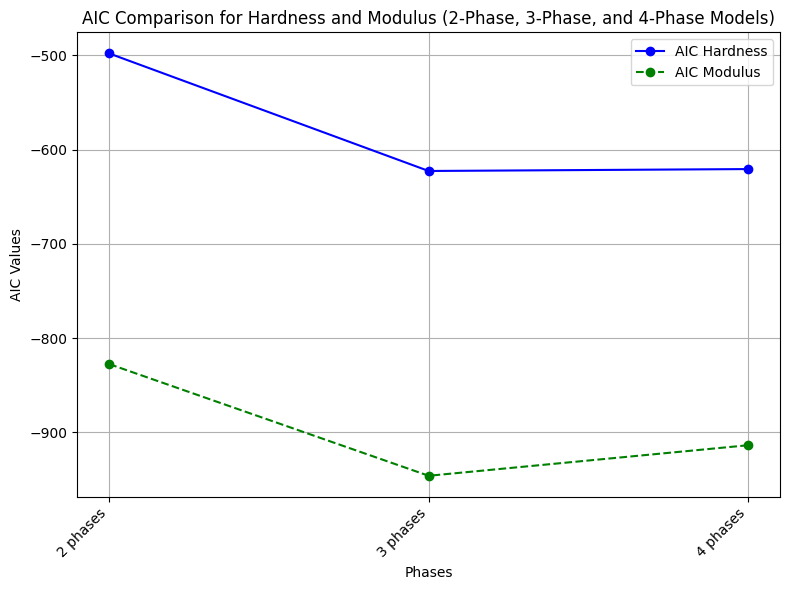

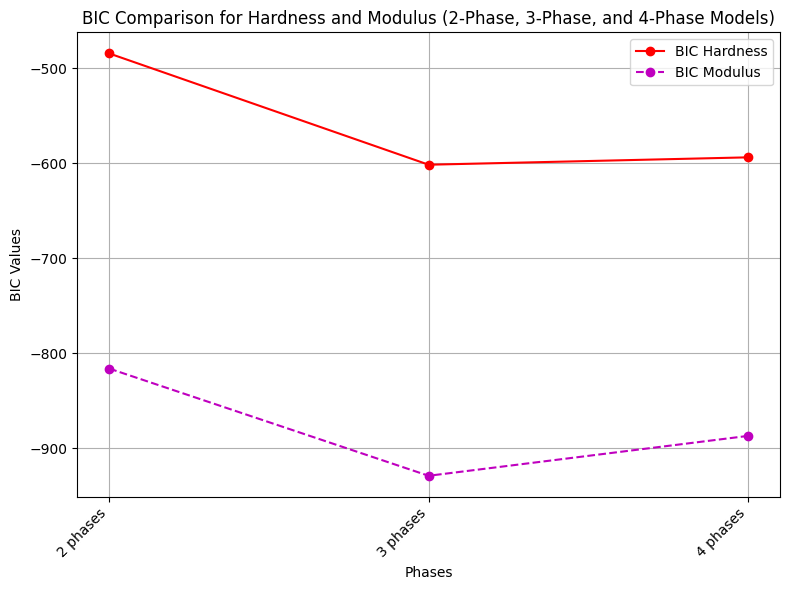

In [26]:
import matplotlib.pyplot as plt
import numpy as np



# Update the labels to include the 4-phase model
labels = ['2 phases', '3 phases', '4 phases']

# Update the AIC and BIC values to include the 4-phase model
aic_values_hardness = [aic_hardness_2phases, aic_hardness_3phases, aic_hardness_4phases]
aic_values_modulus = [aic_modulus_2phases, aic_modulus_3phases, aic_modulus_4phases]
bic_values_hardness = [bic_hardness_2phases, bic_hardness_3phases, bic_hardness_4phases]
bic_values_modulus = [bic_modulus_2phases, bic_modulus_3phases, bic_modulus_4phases]

x = np.arange(len(labels))  # Label locations

# Plot AIC
plt.figure(figsize=(8, 6))
plt.plot(labels, aic_values_hardness, marker='o', linestyle='-', color='b', label='AIC Hardness')
plt.plot(labels, aic_values_modulus, marker='o', linestyle='--', color='g', label='AIC Modulus')
plt.xlabel('Phases')
plt.ylabel('AIC Values')
plt.title('AIC Comparison for Hardness and Modulus (2-Phase, 3-Phase, and 4-Phase Models)')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
plt.show()

# Plot BIC
plt.figure(figsize=(8, 6))
plt.plot(labels, bic_values_hardness, marker='o', linestyle='-', color='r', label='BIC Hardness')
plt.plot(labels, bic_values_modulus, marker='o', linestyle='--', color='m', label='BIC Modulus')
plt.xlabel('Phases')
plt.ylabel('BIC Values')
plt.title('BIC Comparison for Hardness and Modulus (2-Phase, 3-Phase, and 4-Phase Models)')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
plt.show()

